In [150]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import pickle as pkl
import torch
import numpy as np

import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['font.size'] = 18
import matplotlib.pyplot as plt

In [79]:
As = [0,30,60,90,120,150]
C=100
vines = {}
for A in As:
    with open(f'/home/nina/CopulaGP/out/Thy171_sel22_C{C}_A{A}_vine.pkl',"rb") as f:
        vines[A] = pkl.load(f)

In [80]:
orders = {}
for A in [0,30,60,90,120,150]:
    with open(f'/home/nina/CopulaGP/out/Thy171_sel22_C{C}_A{A}_trained.pkl',"rb") as f:
        trained = pkl.load(f)
    orders[A] = trained['order']

In [81]:
collection = {k[0]:[] for k in Data['recs'][0]}

NameError: name 'Data' is not defined

In [103]:
device='cuda:0' # can be cuda, but no need for this here

C=100
A=90
with open(f'/home/nina/CopulaGP/datasets/Thy171_sel22_C{C}_A{A}_layer0.pkl',"rb") as f:
    data = pkl.load(f)

X = data['X'][:131] # contains repetitions of the same 131 values
assert (X[0]==0.) & (X[-1]==1.) # easy sanity check, that ends are [0,1]
inputs = torch.tensor(X, device=device).float()

min, max = data['Y_preord'].min(axis=0), data['Y_preord'].max(axis=0)
Y = np.clip((data['Y_preord'] - min)/(max-min)*0.998+0.001,0.001,0.999)


In [104]:
Train = np.arange(180)[orders[0]]
Test  = np.arange(180)[orders[30]]
re_order = np.argsort(orders[30])[orders[0]]
np.all(Test[re_order]==Train)

True

In [105]:
lls = np.zeros([6,*Y.reshape(-1,131,180).shape[:2]])
for i,trained_on in enumerate(As):
    re_order = orders[trained_on]
    test_Y = torch.tensor(Y[...,re_order].reshape(-1,131,180), device=device).float()
    lls[i] = vines[trained_on].log_prob(test_Y).cpu().numpy()

In [106]:
lik = np.exp(lls)
posterior = lik/lik.sum(0)

In [107]:
import scipy.io
Data = {}
f = scipy.io.loadmat(f'/media/data0/nkudryas/new_data/20200723_Thy171_alldata_selected.mat')
for k,v in f.items():
    Data[k] = v
Data.keys()

contrast = C/1 if C==50 else C/100
trial_mask = (Data['contrast']==contrast) & (Data['orient']==A)
# Data['recs']


In [108]:
this_orient = [Data['recs'][0][i] for i in np.where(trial_mask)[1]]
for i in range(np.sum(trial_mask)):
    collection[this_orient[i][0]].append(posterior[int(A/30),i,:])

NameError: name 'collection' is not defined

Text(0.5, 0, 'time, s')

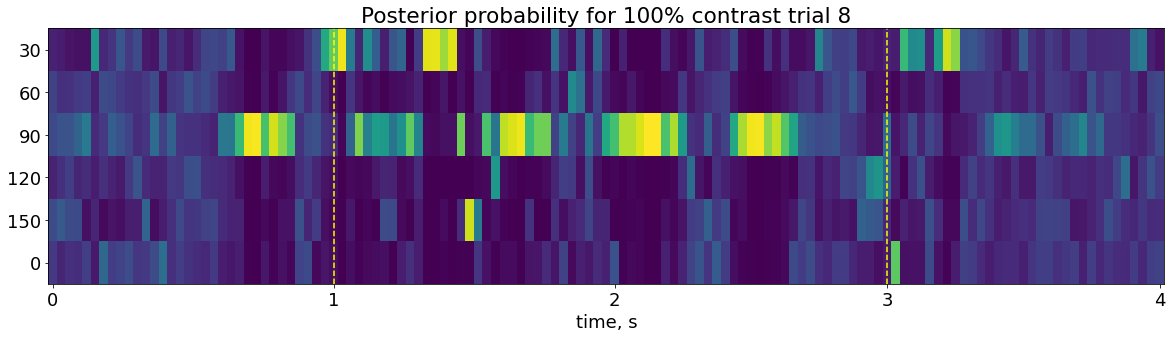

In [121]:
trial=8
plt.imshow(np.roll(np.roll(posterior[:,trial,:],2-int(A/30),axis=0),0,axis=1),aspect=5,interpolation='none',vmin=0,vmax=1)
plt.axvline(33,c='yellow',linestyle='dashed')
plt.axvline(98,c='yellow',linestyle='dashed')
plt.yticks([0,1,2,3,4,5],np.roll([0,30,60,90,120,150],2-int(A/30)));
plt.title(f'Posterior probability for {C}% contrast trial {trial}')
plt.xticks([0,33,66,98,130],[0,1,2,3,4]);
plt.xlabel('time, s')

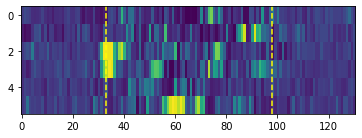

In [61]:
plt.imshow(np.roll(np.array(collection['A_29_1']),5,axis=-1),aspect=7,interpolation='none',vmin=0,vmax=1)
plt.axvline(33,c='yellow',linestyle='dashed')
plt.axvline(98,c='yellow',linestyle='dashed')